In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

 ship  deer plane   dog


In [4]:
import torch.nn as nn
import torch.nn.functional as F

#in a CNN the outchannels generraly increase for the conv layers while they 
# decrease for the fully connected layers
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(color channel, arbritrary1, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(arbritrary1, arbritrary2, 5)
#         self.fc1 = nn.Linear(arbritrary2 * height of out channel* width of out channel, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, arbritrary1 * height of out channel* width of out channel)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
# to calculate height of channel o=((input_size-filter+2*padding)/stride)+1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 60, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(60, 90, 5)
        self.conv3 = nn.Conv2d(90, 120, 5)
        self.fc1 = nn.Linear(120 * 1 * 1, 340)
        self.fc2 = nn.Linear(340,220)
        self.fc3 = nn.Linear(220, 84)
        self.fc4 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 120 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0")
print(device)
if device:
    net.to(device)
    print("Network transfer to GPU")
print("Network transfer on GPU done")


cuda:0
Network transfer to GPU
Network transfer on GPU done


In [5]:
for epoch in range(8):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.302


KeyboardInterrupt: 

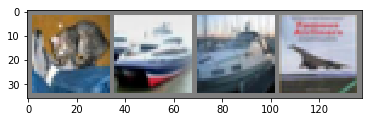

GroundTruth:    cat  ship  ship plane


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [47]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
dataiter = iter(testloader)
images, labels = dataiter.next()


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
net = Net()
net.load_state_dict(torch.load(PATH))

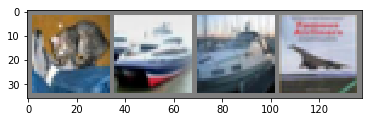

GroundTruth:    cat  ship  ship plane


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [48]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
net = Net()
net.load_state_dict(torch.load(PATH))

In [49]:
net = Net()
net.load_state_dict(torch.load(PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [26]:
net.conv1.weight

Parameter containing:
tensor([[[[-3.2993e-02, -2.3405e-03,  2.1536e-02, -9.9217e-02,  3.8875e-02],
          [-1.4608e-01, -1.2142e-01, -1.3833e-01, -1.1703e-01, -8.1771e-02],
          [-4.3233e-02, -8.1761e-02, -9.9388e-02, -6.4674e-02,  2.0620e-02],
          [ 1.0191e-01,  8.5324e-02,  1.0056e-01,  7.8439e-02,  1.3406e-01],
          [ 1.8527e-01,  2.3297e-01,  2.0644e-01,  8.7565e-02,  2.3663e-01]],

         [[ 1.1522e-02,  6.3033e-02,  2.1163e-01, -1.0223e-03, -4.1490e-02],
          [ 1.8605e-01,  5.1929e-02, -1.4299e-01, -1.6272e-01, -1.0454e-01],
          [ 2.4002e-01,  1.9913e-01, -1.8517e-01, -1.8084e-01, -1.1473e-01],
          [ 9.6181e-02,  1.3058e-01,  7.5518e-03, -6.7408e-02, -2.2133e-01],
          [ 1.0673e-01,  1.1112e-02,  6.9191e-02, -7.7813e-02, -1.6184e-01]],

         [[ 2.8479e-01,  4.1621e-01,  2.1255e-01,  5.1796e-02, -2.4858e-01],
          [ 5.3052e-01,  4.3750e-01,  1.1120e-01, -1.1682e-01, -3.2388e-01],
          [ 5.1614e-01,  3.1956e-01,  3.1955e-02, 

In [2]:
t = torch.tensor([1,2,3])

In [3]:
t = t.cuda()
t

tensor([1, 2, 3], device='cuda:0')

In [4]:
t.device()

TypeError: 'torch.device' object is not callable

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.current_device()

0

In [7]:
torch.cuda.get_device_name()

'GeForce GTX 1070 Ti'